# MNIST VIB
Optimized by `I(Z, X)` estimation


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm.notebook import trange

%matplotlib inline

In [3]:
tf.reset_default_graph()

# Turn on xla optimization
config = tf.ConfigProto(log_device_placement=True)
config.graph_options.optimizer_options.global_jit_level = tf.OptimizerOptions.ON_1
config.gpu_options.allow_growth = True

In [ ]:
from tensorflow.examples.tutorials.mnist import input_data
mnist_data = input_data.read_data_sets('/tmp/mnistdata')

In [5]:
k = 256  # Latent variable dimension

In [6]:
beta = tf.placeholder(tf.float32, shape=(), name='beta')

images = tf.placeholder(tf.float32, [None, 784], 'images')
labels = tf.placeholder(tf.int64, [None], 'labels')
one_hot_labels = tf.one_hot(labels, 10)

other_mus = tf.placeholder(tf.float32, [None, k], 'other_mus')
other_rhos = tf.placeholder(tf.float32, [None, k], 'other_rhos')

In [ ]:
layers = tf.contrib.layers
ds = tf.contrib.distributions

def encoder(images):
    net = layers.relu(2 * images - 1, 1024)
    net = layers.relu(net, 1024)
    params = layers.linear(net, 2 * k)
    mu, rho = params[:, :k], params[:, k:]
    encoding = ds.NormalWithSoftplusScale(mu, rho)
    return mu, rho, encoding

def decoder(encoding_sample):
    net = layers.linear(encoding_sample, 10)
    return net

prior = ds.Normal(0.0, 1.0)

In [ ]:
import math

with tf.variable_scope('encoder'):
    mu, rho, encoding = encoder(images)
    
with tf.variable_scope('decoder'):
    z = encoding.sample()
    logits = decoder(z)
    
with tf.variable_scope('decoder', reuse=True):
    many_logits = decoder(encoding.sample(12))


In [ ]:
# m: len(base_mu), b: batch_size, k: hidden_dim
# inputs: z (b, k), mu (b, k), rho (b, k), other_mus (m, k), other_rhos (m, k)

log_2_pi = tf.log(2 * np.pi)
b = tf.shape(z)[0]

all_mus = tf.concat([mu, other_mus], axis=0)  # (b+m) x k
all_rhos = tf.concat([rho, other_rhos], axis=0)  # (b+m) x k

soft_plused_rho_arr = tf.math.softplus(all_rhos)
inv_cov_arr = 1 / soft_plused_rho_arr  # m x k
log_det_arr = tf.reduce_sum(tf.log(soft_plused_rho_arr), axis=1, keepdims=True)  # m x 1
z_minus_mu_matrix = z - tf.expand_dims(all_mus, 1)  # m x b x k
gaussian_matrix_term = tf.reduce_sum(tf.multiply(
    tf.multiply(z_minus_mu_matrix, z_minus_mu_matrix), 
    tf.expand_dims(inv_cov_arr, axis=1)), 
    axis=2
)  # m x b

log_p_z_given_x = -k/2 * log_2_pi + -1/2 * log_det_arr + -1/2 * gaussian_matrix_term  # axis0: x, axis1: z

log_p_x_i_given_z_i = tf.linalg.tensor_diag_part(log_p_z_given_x[:b, :b]) - tf.reduce_logsumexp(log_p_z_given_x, axis=0)
log_p_x_i_given_z_i /= np.log(2)
estimated_h_x_given_z = -1 * tf.reduce_mean(log_p_x_i_given_z_i)
estimation_std = tf.math.reduce_std(log_p_x_i_given_z_i)

In [10]:
class_loss = tf.losses.softmax_cross_entropy(logits=logits, onehot_labels=one_hot_labels) / math.log(2)
total_loss = class_loss - beta * estimated_h_x_given_z

In [11]:
accuracy = tf.reduce_mean(tf.cast(
    tf.equal(tf.argmax(logits, 1), labels), tf.float32
))
avg_accuracy = tf.reduce_mean(tf.cast(
    tf.equal(tf.argmax(tf.reduce_mean(tf.nn.softmax(many_logits), 0), 1), labels), tf.float32
))
IZY_bound = math.log(10, 2) - class_loss

In [12]:
batch_size = 100
steps_per_batch = int(mnist_data.train.num_examples / batch_size)

In [ ]:
global_step = tf.contrib.framework.get_or_create_global_step()
learning_rate = tf.train.exponential_decay(1e-4, global_step,
                                           decay_steps=2*steps_per_batch,
                                           decay_rate=0.97, staircase=True)
opt = tf.train.AdamOptimizer(learning_rate, 0.5)

ma = tf.train.ExponentialMovingAverage(0.999, zero_debias=True)
ma_update = ma.apply(tf.model_variables())

saver = tf.train.Saver()
saver_polyak = tf.train.Saver(ma.variables_to_restore())

train_tensor = tf.contrib.training.create_train_op(total_loss, opt,
                                                   global_step,
                                                   update_ops=[ma_update])

In [14]:
N_EPOCH = 20
beta_choices = [math.pow(10, x) for x in range(-4, 0)]

n = mnist_data.train.labels.shape[0]
m = 10000

In [15]:
def evaluate(sess, test=False):
    data = mnist_data.validation
    if test:
        data = mnist_data.test
    
    IZY, acc, avg_acc = sess.run([IZY_bound, accuracy, avg_accuracy], feed_dict={images: data.images, labels: data.labels})
    
    other_mus_indices = np.random.choice(list(range(0, n)), m)
    other_mus_np, other_rhos_np = sess.run([mu, rho], feed_dict={images: mnist_data.train.images[other_mus_indices]})
    
    batch_indices = np.random.choice(list(range(0, data.labels.shape[0])), batch_size)
    h_x_given_z, std = sess.run([estimated_h_x_given_z, estimation_std], feed_dict={
        images: data.images[batch_indices], labels: data.labels[batch_indices],
        other_mus: other_mus_np, other_rhos: other_rhos_np
    })

    return IZY, h_x_given_z, std, 1-acc, 1-avg_acc

In [ ]:
results = np.zeros((len(beta_choices), N_EPOCH, 5))

for idx, b in enumerate(beta_choices):
    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer())
        for epoch in trange(N_EPOCH, leave=True):
            for step in trange(steps_per_batch, leave=False):
                batch_indices = range(step * batch_size, (step + 1) * batch_size)
                im, ls = mnist_data.train.images[batch_indices], mnist_data.train.labels[batch_indices]
        
                other_mus_indices = list(set(range(0, n)) - set(batch_indices))
                other_mus_indices = np.random.choice(other_mus_indices, m)
                
                other_mus_np, other_rhos_np = sess.run([mu, rho], feed_dict={images: mnist_data.train.images[other_mus_indices]})
                
                sess.run([train_tensor, estimated_h_x_given_z], feed_dict={
                    images: im, labels: ls, 
                    other_mus: other_mus_np, other_rhos: other_rhos_np, 
                    beta: b
                })
                
            IZY, h_x_given_z, std, err, avg_err = evaluate(sess)
            
            results[idx, epoch, :] = IZY, h_x_given_z, std, err, avg_err
            if epoch > 10 and avg_err > 0.1:  # Ignore non-promising hyperparameters
                break

0.02180004119873047 0.015200018882751465


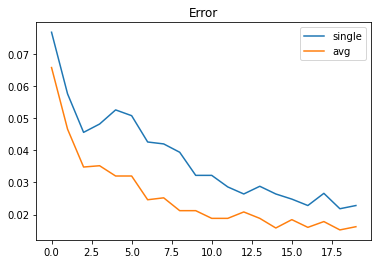

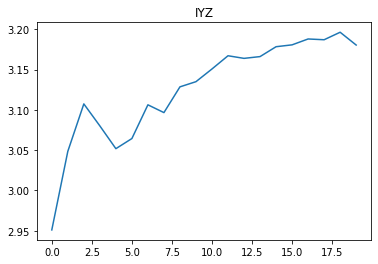

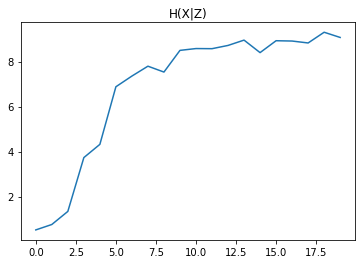

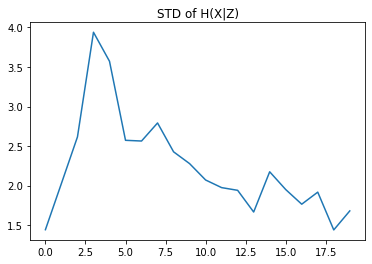

In [24]:
which_run_setting = 3
print(results[which_run_setting, :, 3].min(), results[which_run_setting, :, 4].min())

_, length_ax = plt.subplots()
plt.title('Error')
length_ax.plot(range(N_EPOCH), results[which_run_setting, :, 3], label='single')
length_ax.plot(range(N_EPOCH), results[which_run_setting, :, 4], label='avg')
length_ax.legend()

_, length_ax = plt.subplots()
plt.title('IYZ')
length_ax.plot(range(N_EPOCH), results[which_run_setting, :, 0])

_, length_ax = plt.subplots()
plt.title('H(X|Z)')
length_ax.plot(range(N_EPOCH), results[which_run_setting, :, 1])

_, length_ax = plt.subplots()
plt.title('STD of H(X|Z)')
length_ax.plot(range(N_EPOCH), results[which_run_setting, :, 2])